Время исполнения (базовая модель): 0.347454309463501 секунд(-ы)
Всего штрафов (базовая модель): 440
Штрафы (базовая модель):
Нарушение порядка выполнения: Ремонт оборудования начинается до завершения Подготовка деталей (штраф: 100)
Низкое качество выполнения: Закупка материалов назначена на Мария, который не имеет навыков для этой работы (штраф: 80)
Низкое качество выполнения: Изготовление плафона назначена на Алексей, который не имеет навыков для этой работы (штраф: 80)
Низкое качество выполнения: Уборка рабочего места назначена на Дмитрий, который не имеет навыков для этой работы (штраф: 80)
Перекрытие работ: Петр выполняет Настройка светильника и Установка лампы одновременно (штраф: 100)

Время исполнения (островная модель): 4.085014820098877 секунд(-ы)
Всего штрафов (островная модель): 240
Штрафы (островная модель):
Низкое качество выполнения: Изготовление плафона назначена на Мария, который не имеет навыков для этой работы (штраф: 80)
Низкое качество выполнения: Ремонт оборудовани

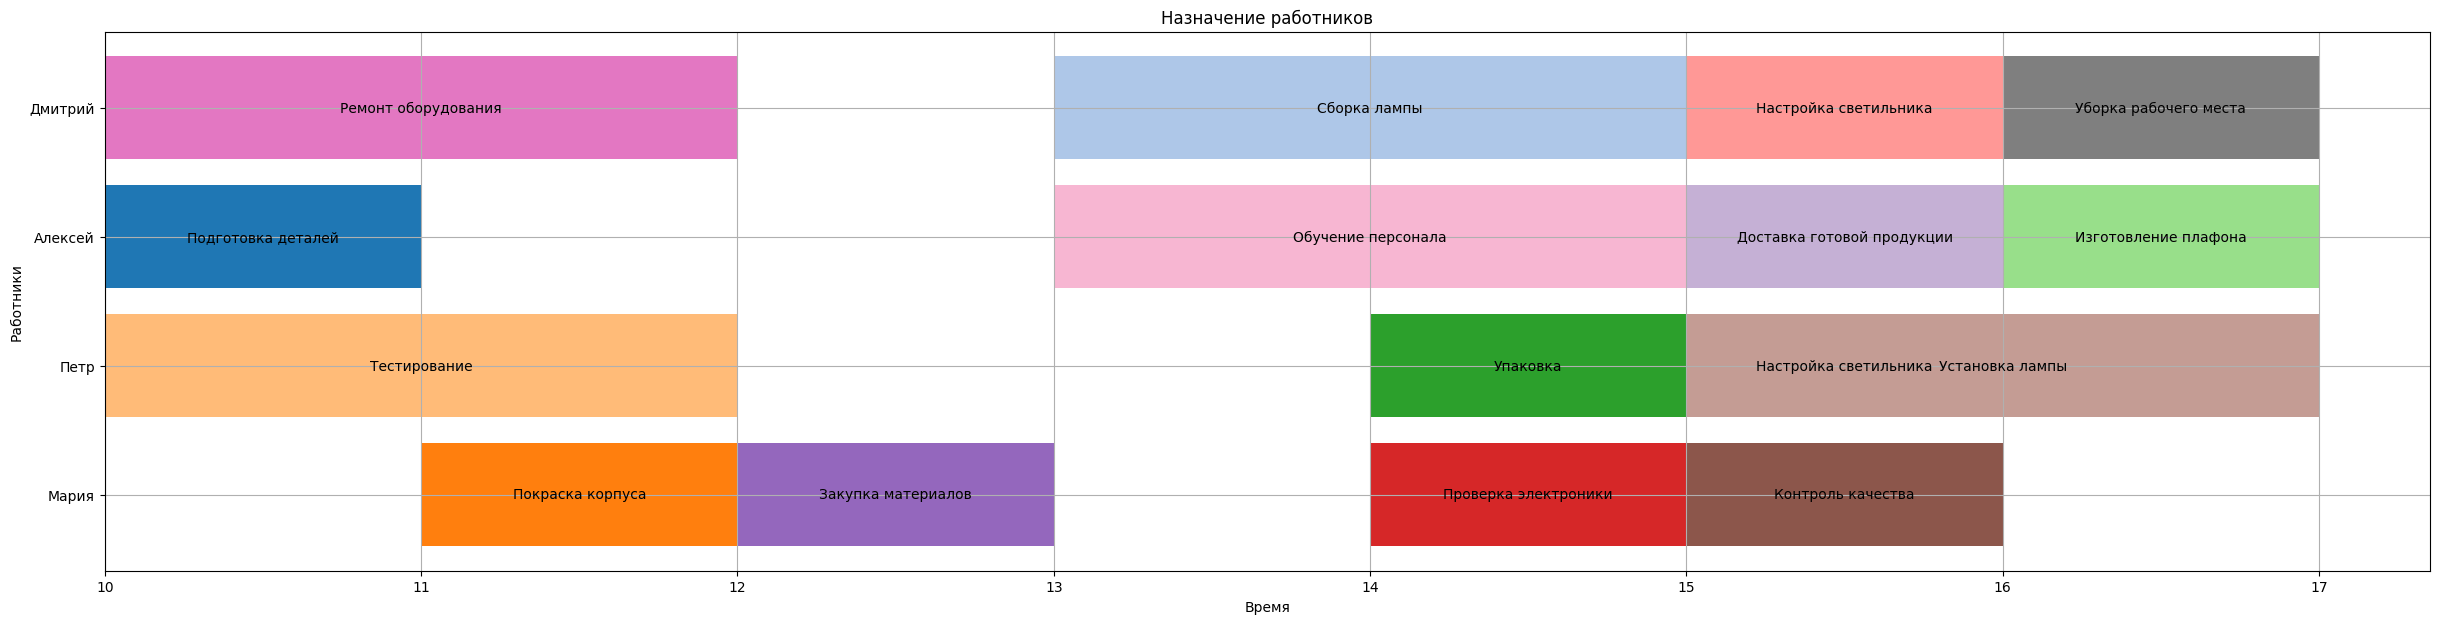

Лучшее назначение (островная модель):


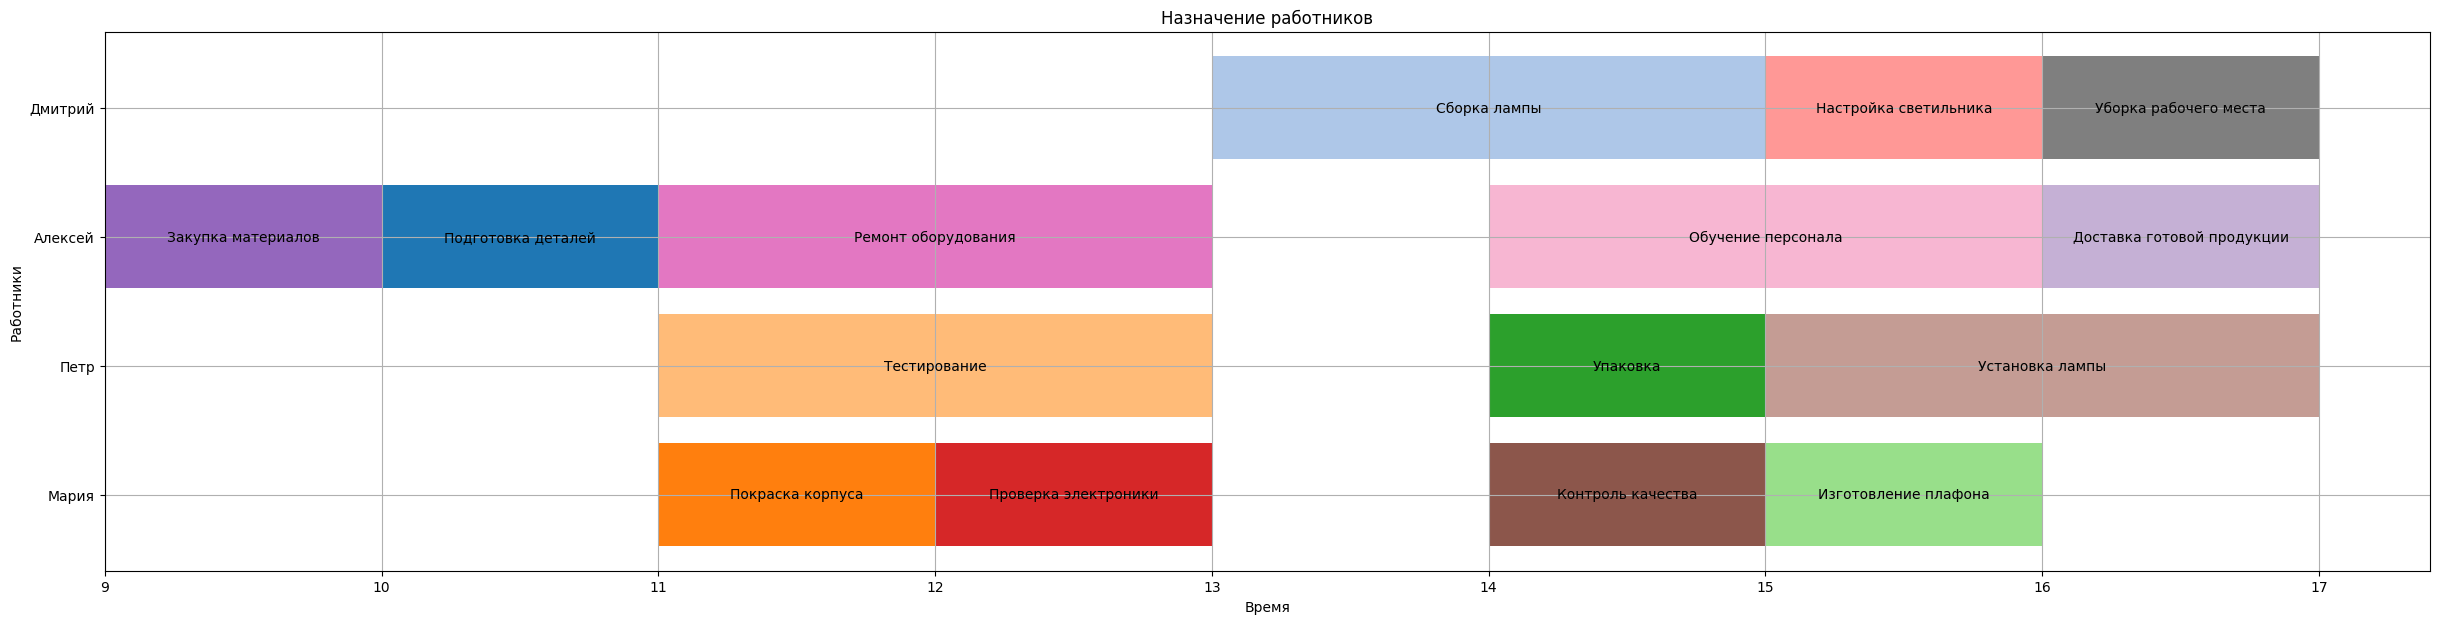

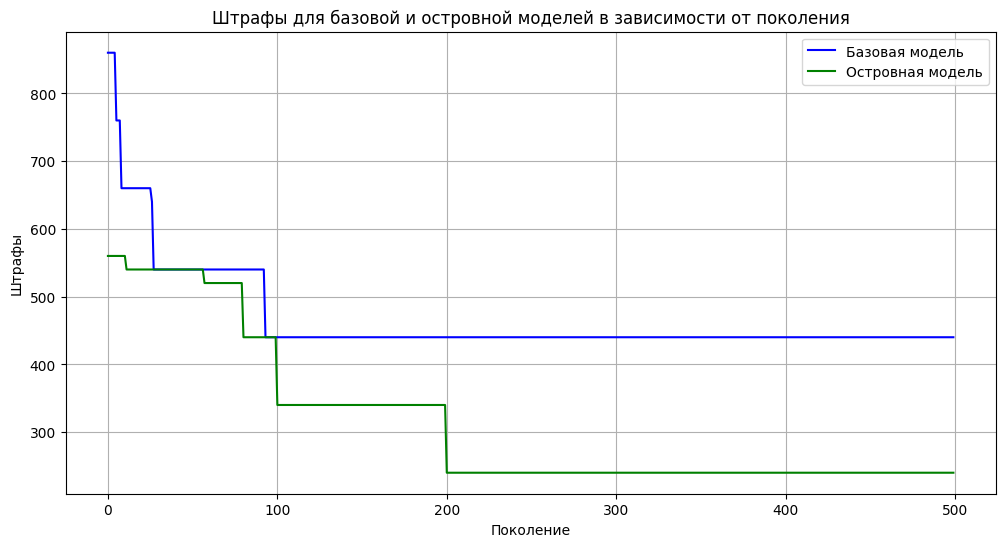

Число островов: 1
Время исполнения (островная модель): 1.390838623046875 секунд(-ы)
Всего штрафов (островная модель): 520

Число островов: 2
Время исполнения (островная модель): 2.022125482559204 секунд(-ы)
Всего штрафов (островная модель): 500

Число островов: 3
Время исполнения (островная модель): 2.9938459396362305 секунд(-ы)
Всего штрафов (островная модель): 440

Число островов: 4
Время исполнения (островная модель): 3.8026883602142334 секунд(-ы)
Всего штрафов (островная модель): 360

Число островов: 5
Время исполнения (островная модель): 4.321390628814697 секунд(-ы)
Всего штрафов (островная модель): 260



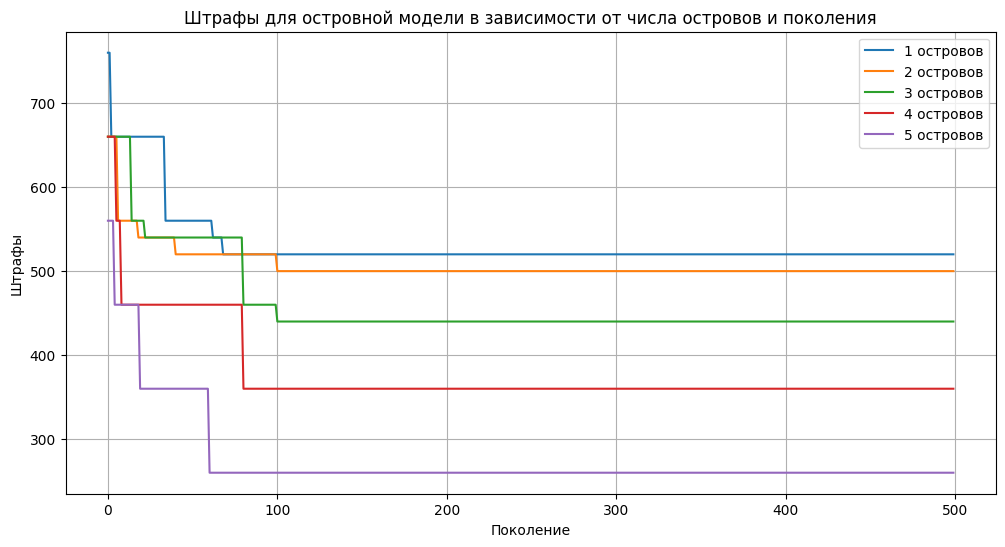

In [3]:
import numpy as np
import time
import random
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Работы
works = [
    {"name": "Подготовка деталей", "start_time": 10, "end_time": 15, "duration": 1, "dependencies": []},
    {"name": "Сборка лампы", "start_time": 10, "end_time": 15, "duration": 2, "dependencies": ["Покраска корпуса"]},
    {"name": "Покраска корпуса", "start_time": 10, "end_time": 15, "duration": 1, "dependencies": ["Подготовка деталей"]},
    {"name": "Тестирование", "start_time": 10, "end_time": 16, "duration": 2, "dependencies": []},
    {"name": "Упаковка", "start_time": 14, "end_time": 17, "duration": 1, "dependencies": ["Тестирование"]},
    {"name": "Изготовление плафона", "start_time": 14, "end_time": 17, "duration": 1, "dependencies": ["Сборка лампы"]},
    {"name": "Проверка электроники", "start_time": 12, "end_time": 15, "duration": 1, "dependencies": []},
    {"name": "Настройка светильника", "start_time": 14, "end_time": 16, "duration": 1, "dependencies": ["Сборка лампы"]},
    {"name": "Закупка материалов", "start_time": 9, "end_time": 13, "duration": 1, "dependencies": []},
    {"name": "Доставка готовой продукции", "start_time": 15, "end_time": 17, "duration": 1, "dependencies": ["Упаковка"]},
    {"name": "Контроль качества", "start_time": 14, "end_time": 17, "duration": 1, "dependencies": ["Тестирование"]},
    {"name": "Установка лампы", "start_time": 14, "end_time": 17, "duration": 2, "dependencies": ["Сборка лампы"]},
    {"name": "Ремонт оборудования", "start_time": 10, "end_time": 14, "duration": 2, "dependencies": ["Подготовка деталей"]},
    {"name": "Обучение персонала", "start_time": 12, "end_time": 17, "duration": 2, "dependencies": []},
    {"name": "Уборка рабочего места", "start_time": 16, "end_time": 17, "duration": 1, "dependencies": []},
]

# Работник
workers = [
    {"name": "Мария", "skills": ["Покраска корпуса", "Тестирование", "Проверка электроники", "Контроль качества"], "max_hours": 8},
    {"name": "Петр", "skills": ["Упаковка", "Тестирование", "Настройка светильника", "Установка лампы"], "max_hours": 8},
    {"name": "Алексей", "skills": ["Закупка материалов", "Подготовка деталей", "Доставка готовой продукции", "Обучение персонала"], "max_hours": 8},
    {"name": "Дмитрий", "skills": ["Сборка лампы", "Проверка электроники", "Ремонт оборудования", "Обучение персонала", "Настройка светильника"], "max_hours": 8},
]

# Штрафы
PENALTY_ORDER_VIOLATION = 100  # Нарушение порядка выполнения
PENALTY_LOW_QUALITY = 80       # Назначение на работу, которую работник не может выполнить качественно
PENALTY_OVERTIME = 100         # Рабочий день более 8 часов
PENALTY_SHORT_LUNCH = 100      # Обеденный перерыв менее часа и не в 12-14
PENALTY_REPEATED_WORK = 80     # Штраф за повторное назначение одной и той же работы одному сотруднику
PENALTY_OVERLAP = 100          # Штраф за одновременное выполнение нескольких работ одним работником
PENALTY_UNASSIGNED_WORK = 1000 # Штраф за невыполненную работу
PENALTY_INCOMPLETE_WORK = 1000  # Штраф за неполное выполнение задачи
PENALTY_TIME_VIOLATION = 1000  # Штраф за нарушение временного интервала

# Функция для создания начальной популяции
def create_schedule():
    schedule = [[] for _ in workers]  # Назначение для каждого работника
    assigned_works = set()  # Множество для отслеживания назначенных работ

    for work in works:
        # Выбираем случайного работника, который может выполнить задачу
        possible_workers = [worker_idx for worker_idx, worker in enumerate(workers) if work["name"] in worker["skills"]]
        if not possible_workers:
            # Если никто не может выполнить задачу, выбираем любого работника
            possible_workers = range(len(workers))

        worker_idx = random.choice(possible_workers)
        start_time = random.randint(work["start_time"], work["end_time"] - work["duration"])
        schedule[worker_idx].append((work["name"], start_time, start_time + work["duration"]))
        assigned_works.add(work["name"])

    return schedule


def evaluate_schedule(schedule):
    penalty = 0
    penalty_details = []  # Список для хранения информации о штрафах

    # Создаем словарь для хранения времени выполнения задач
    task_times = {}
    for worker_schedule in schedule:
        for task in worker_schedule:
            task_name, start_time, end_time = task
            task_times[task_name] = (start_time, end_time)

    # Проверяем порядок выполнения задач
    for work in works:
        for dependency in work["dependencies"]:
            if dependency in task_times and work["name"] in task_times:
                dependency_start, dependency_end = task_times[dependency]
                work_start, work_end = task_times[work["name"]]

                # Проверяем, выполняется ли задача до завершения зависимости
                if work_start < dependency_end:
                    penalty += PENALTY_ORDER_VIOLATION
                    penalty_details.append(f"Нарушение порядка выполнения: {work['name']} начинается до завершения {dependency} (штраф: {PENALTY_ORDER_VIOLATION})")

    # Проверка качества выполнения работ
    for worker_schedule in schedule:
        worker = workers[schedule.index(worker_schedule)]
        for task in worker_schedule:
            if task[0] not in worker["skills"]:
                penalty += PENALTY_LOW_QUALITY
                penalty_details.append(f"Низкое качество выполнения: {task[0]} назначена на {worker['name']}, который не имеет навыков для этой работы (штраф: {PENALTY_LOW_QUALITY})")

    # Проверка рабочего времени и обеденного перерыва
    for worker_schedule in schedule:
        total_hours = sum(task[2] - task[1] for task in worker_schedule)
        if total_hours > 8:
            penalty += PENALTY_OVERTIME
            penalty_details.append(f"Переработка: {workers[schedule.index(worker_schedule)]['name']} работает более 8 часов (штраф: {PENALTY_OVERTIME})")

        # Проверка обеденного перерыва
        lunch_found = False

        # Проверяем интервал 12:00 - 13:00
        slot_free = True
        for task in worker_schedule:
            task_start, task_end = task[1], task[2]
            if not (task_end <= 12 or task_start >= 13):  # Задача пересекается с 12:00 - 13:00
                slot_free = False
                break
        if slot_free:
            lunch_found = True

        # Проверяем интервал 13:00 - 14:00
        if not lunch_found:
            slot_free = True
            for task in worker_schedule:
                task_start, task_end = task[1], task[2]
                if not (task_end <= 13 or task_start >= 14):  # Задача пересекается с 13:00 - 14:00
                    slot_free = False
                    break
            if slot_free:
                lunch_found = True

        # Если обеденный перерыв не найден, начисляем штраф
        if not lunch_found:
            penalty += PENALTY_SHORT_LUNCH
            penalty_details.append(f"Отсутствие обеденного перерыва: {workers[schedule.index(worker_schedule)]['name']} не имеет обеда (штраф: {PENALTY_SHORT_LUNCH})")

    # Проверка повторного назначения одной и той же работы одному сотруднику
    for worker_schedule in schedule:
        tasks = [task[0] for task in worker_schedule]
        if len(tasks) != len(set(tasks)):
            penalty += PENALTY_REPEATED_WORK
            penalty_details.append(f"Повторное назначение работы: {workers[schedule.index(worker_schedule)]['name']} назначен на одну и ту же работу несколько раз (штраф: {PENALTY_REPEATED_WORK})")

    # Проверка одновременного выполнения нескольких работ одним работником
    for worker_schedule in schedule:
        for i in range(len(worker_schedule)):
            for j in range(i + 1, len(worker_schedule)):
                task1 = worker_schedule[i]
                task2 = worker_schedule[j]
                if task1[1] < task2[2] and task2[1] < task1[2]:
                    penalty += PENALTY_OVERLAP
                    penalty_details.append(f"Перекрытие работ: {workers[schedule.index(worker_schedule)]['name']} выполняет {task1[0]} и {task2[0]} одновременно (штраф: {PENALTY_OVERLAP})")

    # Проверка, что все работы выполнены
    assigned_works = set()
    for worker_schedule in schedule:
        for task in worker_schedule:
            assigned_works.add(task[0])
    for work in works:
        if work["name"] not in assigned_works:
            penalty += PENALTY_UNASSIGNED_WORK
            penalty_details.append(f"Невыполненная работа: {work['name']} не назначена ни одному работнику (штраф: {PENALTY_UNASSIGNED_WORK})")

    # Проверка, что задачи выполнены полностью (продолжительность равна duration)
    for worker_schedule in schedule:
        for task in worker_schedule:
            task_name, start_time, end_time = task
            work = next(w for w in works if w["name"] == task_name)
            if (end_time - start_time) != work["duration"]:
                penalty += PENALTY_INCOMPLETE_WORK
                penalty_details.append(f"Неполное выполнение задачи: {task_name} выполнена за {end_time - start_time} часа(ов) вместо {work['duration']} (штраф: {PENALTY_INCOMPLETE_WORK})")

    # Проверка, что задачи выполняются в пределах start_time и end_time
    for worker_schedule in schedule:
        for task in worker_schedule:
            task_name, start_time, end_time = task
            work = next(w for w in works if w["name"] == task_name)
            if start_time < work["start_time"] or end_time > work["end_time"]:
                penalty += PENALTY_TIME_VIOLATION
                penalty_details.append(f"Нарушение временного интервала: {task_name} выполняется вне допустимого времени ({work['start_time']}:00 - {work['end_time']}:00) (штраф: {PENALTY_TIME_VIOLATION})")

    return penalty, penalty_details

# Функция мутации
def mutate_schedule(schedule):
    mutated_schedule = [worker_schedule.copy() for worker_schedule in schedule]

    # Выбираем случайного работника
    worker_idx = random.randint(0, len(mutated_schedule) - 1)
    worker_schedule = mutated_schedule[worker_idx]

    if len(worker_schedule) > 0:
        # Выбираем случайную задачу у этого работника
        task_idx = random.randint(0, len(worker_schedule) - 1)
        task = worker_schedule[task_idx]
        task_name, start_time, end_time = task

        # Варианты мутации:
        if random.random() < 0.5:
            # Мутация 1: Изменяем время выполнения задачи
            new_start_time = random.randint(works[task_idx]["start_time"], works[task_idx]["end_time"] - works[task_idx]["duration"])
            worker_schedule[task_idx] = (task_name, new_start_time, new_start_time + works[task_idx]["duration"])
        else:
            # Мутация 2: Перемещаем задачу другому работнику
            new_worker_idx = random.randint(0, len(mutated_schedule) - 1)
            if new_worker_idx != worker_idx:
                mutated_schedule[worker_idx].pop(task_idx)
                mutated_schedule[new_worker_idx].append((task_name, start_time, end_time))

    return mutated_schedule

# Функция кроссовера
def crossover(parent1, parent2):
    child1 = []
    child2 = []

    for i in range(len(parent1)):
        if random.random() < 0.5:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])

    return child1, child2

# Функция отбора лучших назначений
def select_best_schedules(population, num_best=5):
    evaluated_population = [(schedule, evaluate_schedule(schedule)[0]) for schedule in population]
    evaluated_population.sort(key=lambda x: x[1])
    return [schedule for schedule, _ in evaluated_population[:num_best]]

# Основной алгоритм
def genetic_algorithm(num_generations=500, population_size=20):
    population = [create_schedule() for _ in range(population_size)]
    penalties = []

    for generation in range(num_generations):
        # Оценка популяции
        evaluated_population = [(schedule, evaluate_schedule(schedule)[0]) for schedule in population]
        evaluated_population.sort(key=lambda x: x[1])
        
        # Отбор лучших назначений
        best_schedules = [schedule for schedule, _ in evaluated_population[:population_size // 2]]
        
        # Создание нового поколения
        new_population = best_schedules.copy()
        while len(new_population) < population_size:
            # Выбор двух родителей
            parent1, parent2 = random.choices(best_schedules, k=2)
            
            # Скрещивание (кроссовер)
            child1, child2 = crossover(parent1, parent2)
            
            # Мутация
            if random.random() < 0.1:  # Вероятность мутации 10%
                child1 = mutate_schedule(child1)
            if random.random() < 0.1:
                child2 = mutate_schedule(child2)
            
            new_population.extend([child1, child2])

        population = new_population
        penalties.append(evaluated_population[0][1])

    return population[0], penalties

# Островная модель
def island_model(num_generations=500, population_size=40, num_islands=5, migration_rate=20):
    islands = [[create_schedule() for _ in range(population_size)] for _ in range(num_islands)]
    penalties = []

    for generation in range(num_generations):
        for i in range(num_islands):
            # Оценка и отбор на каждом острове
            evaluated_population = [(schedule, evaluate_schedule(schedule)[0]) for schedule in islands[i]]
            evaluated_population.sort(key=lambda x: x[1])
            best_schedules = [schedule for schedule, _ in evaluated_population[:population_size // 2]]
            
            # Создание нового поколения на острове
            new_population = best_schedules.copy()
            while len(new_population) < population_size:
                parent1, parent2 = random.choices(best_schedules, k=2)
                child1, child2 = crossover(parent1, parent2)
                if random.random() < 0.1:
                    child1 = mutate_schedule(child1)
                if random.random() < 0.1:
                    child2 = mutate_schedule(child2)
                new_population.extend([child1, child2])
            
            islands[i] = new_population

        # Миграция между островами
        if generation % migration_rate == 0:
            best_solutions = [select_best_schedules(island, num_best=1)[0] for island in islands]
            for i in range(num_islands):
                next_island = (i + 1) % num_islands
                islands[next_island].append(best_solutions[i])
                if len(islands[next_island]) > population_size:
                    islands[next_island] = select_best_schedules(islands[next_island], num_best=population_size)

        penalties.append(evaluate_schedule(select_best_schedules(islands[0], num_best=1)[0])[0])

    best_schedules = [select_best_schedules(island, num_best=1)[0] for island in islands]
    best_schedule = min(best_schedules, key=lambda s: evaluate_schedule(s)[0])
    return best_schedule, penalties, best_schedules

# Визуализация назначения
def visualize_schedule(schedule):
    fig, ax = plt.subplots(figsize=(30, 7))
    colors = plt.cm.tab20.colors  # Цвета для задач

    # Создаем словарь для хранения цветов задач
    task_colors = {work["name"]: colors[i % len(colors)] for i, work in enumerate(works)}

    for i, worker_schedule in enumerate(schedule):
        for task in worker_schedule:
            # Используем duration из works, а не из task
            work = next(w for w in works if w["name"] == task[0])
            duration = work["duration"]
            # Позиция по Y: i (целое число, соответствующее индексу работника)
            ax.barh(i, duration, left=task[1], color=task_colors[task[0]], height=0.8)  # height регулирует высоту столбца
            # Текст задачи по центру столбца
            ax.text((task[1] + task[1] + duration) / 2, i, task[0], ha='center', va='center', color='black')

    # Настройка оси Y
    ax.set_yticks(range(len(workers)))  # Метки по оси Y соответствуют индексам работников
    ax.set_yticklabels([worker["name"] for worker in workers])  # Подписи — имена работников
    ax.set_xlabel("Время")
    ax.set_ylabel("Работники")
    ax.set_title("Назначение работников")
    plt.grid(True)
    plt.show()

# Функция для текстового вывода назначения
def print_schedule(schedule):
    for i, worker_schedule in enumerate(schedule):
        worker = workers[i]
        print(f"Работник: {worker['name']}")
        for task in worker_schedule:
            task_name, start_time, end_time = task
            print(f"  - Задача: {task_name}, Время: {start_time}:00 - {end_time}:00")
        print()  # Пустая строка для разделения работников

# Сравнение моделей
def run_experiments():
    # Базовая модель
    start_time = time.time()
    best_schedule_base, penalties_base = genetic_algorithm()
    end_time = time.time()
    execution_time_base = end_time - start_time
    total_penalty_base, penalty_details_base = evaluate_schedule(best_schedule_base)

    # Островная модель
    start_time = time.time()
    best_schedule_island, penalties_island, best_schedules_island = island_model()
    end_time = time.time()
    execution_time_island = end_time - start_time
    total_penalty_island, penalty_details_island = evaluate_schedule(best_schedule_island)

    # Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(penalties_base, penalties_island)

    # Вывод результатов
    print(f"Время исполнения (базовая модель): {execution_time_base} секунд(-ы)")
    print(f"Всего штрафов (базовая модель): {total_penalty_base}")
    print("Штрафы (базовая модель):")
    for detail in penalty_details_base:
        print(detail)
    print()

    print(f"Время исполнения (островная модель): {execution_time_island} секунд(-ы)")
    print(f"Всего штрафов (островная модель): {total_penalty_island}")
    print("Штрафы (островная модель):")
    for detail in penalty_details_island:
        print(detail)
    print()

    print(f"Статистика Wilcoxon: {statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("Отвергаем нулевую гипотезу, результаты моделей статистически значимо различаются.")
    else:
        print("Не можем отвергнуть нулевую гипотезу, результаты моделей не статистически значимо различаются.")
    print()

    # Вывод лучшего назначения в текстовом формате
    print("Лучшее назначение (базовая модель):")
    print_schedule(best_schedule_base)

    print("Лучшее назначение (островная модель):")
    print_schedule(best_schedule_island)

    # Визуализация назначения
    print("Лучшее назначение (базовая модель):")
    visualize_schedule(best_schedule_base)

    print("Лучшее назначение (островная модель):")
    visualize_schedule(best_schedule_island)

    # График штрафов для базовой и островной моделей
    plt.figure(figsize=(12, 6))
    plt.plot(penalties_base, label="Базовая модель", color="blue")
    plt.plot(penalties_island, label="Островная модель", color="green")
    plt.xlabel("Поколение")
    plt.ylabel("Штрафы")
    plt.title("Штрафы для базовой и островной моделей в зависимости от поколения")
    plt.legend()
    plt.grid(True)
    plt.show()

# График: Штрафы для островной модели в зависимости от числа островов и поколения
def plot_island_penalties():
    num_islands_list = [1, 2, 3, 4, 5]
    num_generations = 500
    plt.figure(figsize=(12, 6))

    for num_islands in num_islands_list:
        start_time = time.time()
        _, penalties, _ = island_model(num_generations=num_generations, num_islands=num_islands)
        end_time = time.time()
        execution_time = end_time - start_time
        total_penalty = penalties[-1]

        print(f"Число островов: {num_islands}")
        print(f"Время исполнения (островная модель): {execution_time} секунд(-ы)")
        print(f"Всего штрафов (островная модель): {total_penalty}")
        print()

        plt.plot(penalties, label=f"{num_islands} островов")

    plt.xlabel("Поколение")
    plt.ylabel("Штрафы")
    plt.title("Штрафы для островной модели в зависимости от числа островов и поколения")
    plt.legend()
    plt.grid(True)
    plt.show()

# Запуск экспериментов
run_experiments()
plot_island_penalties()